In [1]:
import numpy as np
from numpy import *
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

In [2]:
def Plotflow(Xd, Yd, t, f):
    # Plot phase plane 
    DX, DY = f([Xd, Yd],t)
    # DX=DX/np.linalg.norm(DX, ord=2, axis=1, keepdims=True)
    # DY=DY/np.linalg.norm(DY, ord=2, axis=1, keepdims=True)
    plt.streamplot(Xd,Yd,DX,DY, color=('gray'), linewidth=0.5,
                  density=0.95, arrowstyle='-|>', arrowsize=1.5)
    
def Plot3D(X, Y, V, r=None):
    # Plot Lyapunov functions  
    fig = plt.figure()
    ax = fig.add_subplot(projection = '3d')
    ax.plot_surface(X,Y,V, rstride=5, cstride=5, alpha=0.5, cmap=cm.coolwarm)
    ax.contour(X,Y,V,10, zdir='z', offset=0, cmap=cm.coolwarm)
    
    if r is not None:
        # Plot Valid region computed by dReal
        theta = np.linspace(0,2*np.pi,50)
        xc = r*cos(theta)
        yc = r*sin(theta)
        ax.plot(xc[:],yc[:],'r',linestyle='--', linewidth=2 ,label='Valid region')
        plt.legend(loc='upper right')
    return ax

In [3]:
import numpy as np
import torch
from torch import nn
# import dreal as d

class TanhNetwork(nn.Module):
    def __init__(self, dims, final_act='tanh'):
        super().__init__()
        self.dims = dims
        self.final_act = final_act
        
        layers = []
        for i in range(len(dims)-2):
            layers.append( nn.Linear(dims[i], dims[i+1]) )
            layers.append( nn.Tanh() )
        
        layers.append( nn.Linear(dims[-2], dims[-1]) )
        if final_act == 'tanh':
            layers.append( nn.Tanh())
        elif final_act == 'sigmoid':
            layers.append( nn.Sigmoid() )
        else:
            raise "Not Implemented"
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x).squeeze(-1)
    
    def forward_with_grad(self, x):
        """
        This function should only be called when dims[-1]=1
        :param x: [batch, input_dim]
        :return:
            y: [batch,]
            grad: [batch, input_dim], grad[i] = d/dx f(x_i)
        """
        assert self.dims[-1] == 1
        y = self(x)

        # grad f(x)
        jacob = torch.autograd.functional.jacobian(
            self,
            (x,),
            create_graph=True
        )
        jacob = jacob[0]  # [batch, batch, dim]
        grad = torch.diagonal(jacob).T  # diagonal(shape (3,3,2)) gives (2,3), but we want (3,2)
        
        return y, grad
    
    def get_param_pair(self):
        """get_param_pair
        
        :return:
        ws: Weight variables in relu network
        bs: Bias variables in relu network
        ws and bs must have the same length
        
        """
        ws = []
        bs = []
        
        for name, param in self.layers.named_parameters():
        
            if "weight" in name:
                # print(param.shape)
                ws.append(param.cpu().detach().numpy())
            elif "bias" in name:
                # print(param.shape)
                bs.append(param.cpu().detach().numpy())
        if len(bs) == 0:
            bs = [
                np.zeros([w.shape[0]]) for w in ws
            ]
        return ws, bs
    
    
def torch_to_np(x):
    return x.cpu().detach().numpy()

def np_to_torch(x):
	return torch.from_numpy(x).float().to('cpu')

def pipe(x, *funcs):
	for f in funcs:
		x = f(x)
	return x

# Inverted Pendulum

In [4]:
X = np.linspace(-9, 9, 100) 
Y = np.linspace(-9, 9, 100)
x1, x2 = np.meshgrid(X,Y)

ckpt = torch.load('./pendulum/ckpts/3000.pth', map_location='cpu')
network = TanhNetwork([2, 20, 20, 1], final_act='sigmoid')
network.load_state_dict(ckpt['W'])
actor = TanhNetwork([2, 5, 5, 1], final_act='tanh')
actor.load_state_dict(ckpt['C'])


def f_ours(y, t):
    #parameters
    G = 9.81 
    L = 0.5  
    m = 0.15  
    b = 0.1  
    x1, x2 = y
    
    u = pipe(
        np.stack([x1, x2], axis=-1),
        np_to_torch,
        actor,
        torch_to_np,
    )
    dydt = [x2,  (m*G*L*sin(x1) + u - b*x2) / (m*L**2)]
    return dydt


V_lqr = 1.40973028*x1**2 + 2*0.07414696*x1*x2 + 0.03660902*x2**2 #narrow
V_nlc = tanh((0.1592191 + 0.6047373* tanh((-1.2250961 - 1.1751087 * x1 + 0.028802002 * x2)) - 0.69419956 * tanh((-0.81576663 + 0.02652748* x1 - 0.00072127824999999998 * x2)) - 1.1177092 * tanh((-0.53083205 + 0.043899357 * x1 - 0.0029811477000000002 * x2)) - 1.1329674000000001 * tanh((0.89248989999999995 - 0.55178492999999995 * x1 - 0.034781724 * x2)) + 0.77995585999999995 * tanh((0.93392560000000002 - 0.0067463684999999997 * x1 - 0.0067418180000000001 * x2)) - 0.26213419999999998 * tanh((1.0895116 + 0.44463265000000002 * x1 + 0.2598702 * x2))))-0.212
V_ours = torch_to_np(
    network(
        np_to_torch(np.stack([x1, x2], axis=-1))
    )
)

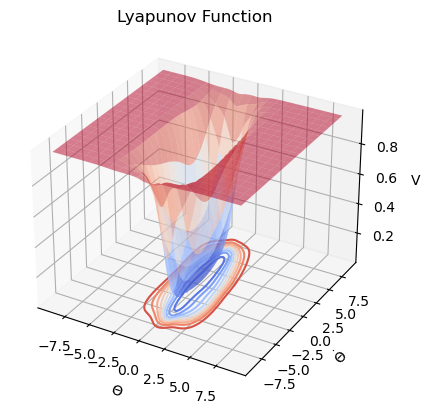

In [5]:
ax = Plot3D(x1,x2,V_ours)
ax.set_xlabel('$\Theta$')
ax.set_ylabel('$\dot{\Theta}$')
ax.set_zlabel('V')
plt.title('Lyapunov Function')
plt.savefig('./pendulum/pendulum_3d.png')
plt.show()
plt.close()

/var/folders/qm/flyz5txs1c79_bp8msg25mqc0000gn/T/ipykernel_64610/2998804621.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'
  ax.contour(X,Y,V_ours, [0.7], linewidth=2, colors='r')


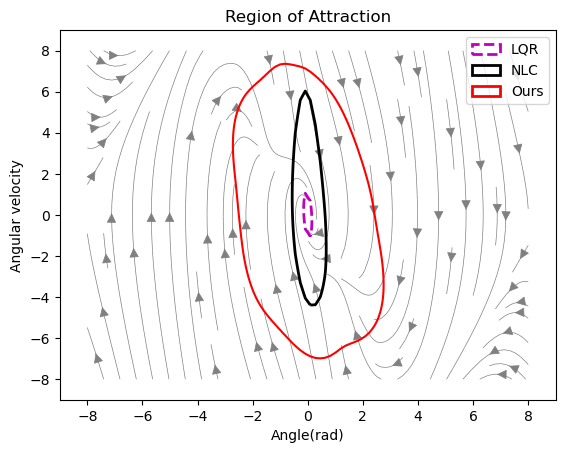

In [6]:
ax = plt.gca()
# Vaild Region
# C = plt.Circle((0, 0),6, color='r', linewidth=1.5, fill=False)
# ax.add_artist(C)

# Ours
# C1 = plt.Rectangle((-4, -8), 8, 16, color='g', linewidth=1.5, fill=False)
# ax.add_artist(C1)

# plot direction field
xd = np.linspace(-8, 8, 10) 
yd = np.linspace(-8, 8, 10)
Xd, Yd = np.meshgrid(xd,yd)
t = np.linspace(0,2,100)
# Plotflow(Xd, Yd, t, f) 
Plotflow(Xd, Yd, t, f_ours) 

ax.contour(X,Y,V_lqr, [0.0384],linewidths=2, colors='m',linestyles='--')
ax.contour(X,Y,V_nlc-0.11,0,linewidths=2, colors='k')
ax.contour(X,Y,V_ours, [0.7], linewidth=2, colors='r')


# ax.contour(x1,x2,V,8,linewidths=0.4, colors='k')
# c1 = ax.contourf(x1,x2,V,8,alpha=0.4,cmap=cm.coolwarm)
# plt.colorbar(c1)

plt.title('Region of Attraction')
plt.legend(
    [
        plt.Rectangle((0,0),1,2,color='m',fill=False,linewidth = 2,linestyle='--'),
        plt.Rectangle((0,0),1,2,color='k',fill=False,linewidth = 2),
        plt.Rectangle((0,0),1,2,color='r',fill=False,linewidth = 2)
    ],
    [
        'LQR',
        'NLC', 
        'Ours'],
    loc='upper right'
)

plt.xlabel('Angle(rad)')
plt.ylabel('Angular velocity')
plt.savefig('./pendulum/pendulum_2d.png')
plt.show()

# Tracking

In [7]:
X = np.linspace(-1.3, 1.3, 100) 
Y = np.linspace(-1.3, 1.3, 100)
x1, x2 = np.meshgrid(X,Y)

ckpt = torch.load('./tracking/ckpts/3000.pth', map_location='cpu')
network = TanhNetwork([2, 20, 20, 1], final_act='sigmoid')
network.load_state_dict(ckpt['W'])
actor = TanhNetwork([2, 10, 10, 1], final_act='tanh')
actor.load_state_dict(ckpt['C'])

def f_ours(y, t):
    v = 6
    L = 1
    x1,x2 = y
    u = pipe(
        np.stack([x1, x2], axis=-1),
        np_to_torch,
        actor,
        torch_to_np
    )
    
    dydt = [v*sin(x2),
            v*tan(u)/L- np.cos(x2) / (1 - x1)]
    return dydt

V_nlc = tanh((0.099664619999999995 + 0.6251369 * tanh((-1.2775723999999999 - 2.5249655 * x1 - 0.18407556 * x2)) - 1.0490067000000001 * tanh((-0.46410936000000003 - 0.47741896 * x1 - 0.69643679999999997 * x2)) - 1.0708085000000001 * tanh((-0.3698631 - 0.52394079999999998 * x1 - 0.58617014000000001 * x2)) + 0.46437746000000002 * tanh((0.91936094000000002 - 0.023182843000000002 * x1 - 0.50320260000000006 * x2)) + 0.70194889999999999 * tanh((0.97582674000000003 - 0.062661019999999998 * x1 - 0.56203824000000002 * x2)) - 1.1286860000000001 * tanh((1.3282121 + 1.3561938 * x1 + 2.5183802000000002 * x2))))-0.27

V_lqr = 0.27734328*x1**2 + 2*0.14118785*x1*x2 + 0.27356972*x2**2

V_ours = pipe(
    np.stack([x1, x2], axis=-1),
    np_to_torch,
    network,
    torch_to_np
)

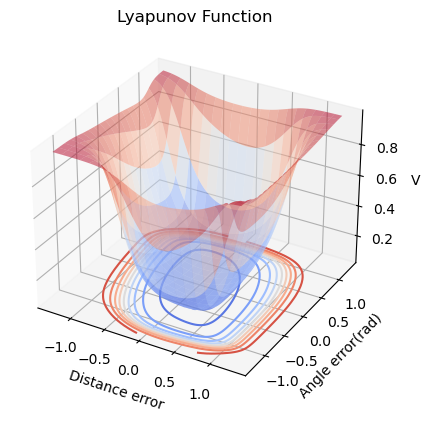

In [8]:
ax = Plot3D(x1,x2,V_ours)
ax.set_xlabel('Distance error')
ax.set_ylabel('Angle error(rad)')
ax.set_zlabel('V')
plt.title('Lyapunov Function')
plt.savefig('./tracking/tracking_3d.png')
plt.show()

/var/folders/qm/flyz5txs1c79_bp8msg25mqc0000gn/T/ipykernel_64610/2731095669.py:15: UserWarning: The following kwargs were not used by contour: 'linewidth'
  ax.contour(x1,x2,V_ours,[0.4], linewidth=2, colors='r')


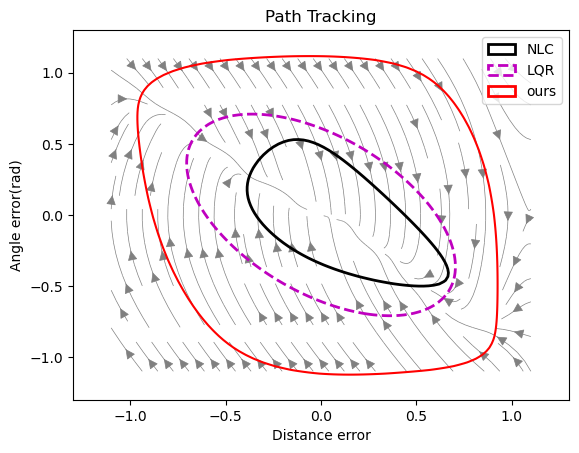

In [9]:
ax = plt.gca()
# C = plt.Circle((0, 0),0.8, color='r', linewidth=1.5, fill=False, label='ROA')
# ax.add_artist(C)

# plot direction field
xd = np.linspace(-1.1, 1.1, 10) 
yd = np.linspace(-1.1, 1.1, 10)
Xd, Yd = np.meshgrid(xd,yd)
t = np.linspace(0,2,100)
Plotflow(Xd, Yd, t, f_ours) 

# ax.contour(x1,x2,V_lqr-0.01200,0,linewidths=2, colors='m',linestyles='--')
ax.contour(x1,x2,V_lqr-0.101509,0,linewidths=2, colors='m',linestyles='--')
ax.contour(x1,x2,V_nlc-0.15,0,linewidths=2, colors='k')
ax.contour(x1,x2,V_ours,[0.4], linewidth=2, colors='r')




plt.title('Region of Attraction')
plt.title('Path Tracking')
plt.legend(
    [
        plt.Rectangle((0,0),1,2,color='k',fill=False,linewidth = 2),
        plt.Rectangle((0,0),1,2,color='m',fill=False,linewidth = 2,linestyle='--'),
        plt.Rectangle((0,0),1,2,color='r',fill=False,linewidth = 2),
    ],
    [
        'NLC',
        'LQR',
        'ours'
    ],
    loc='upper right')
plt.xlabel('Distance error')
plt.ylabel('Angle error(rad)')
plt.savefig('./tracking/tracking_2d.png')
plt.show()

# Double Integrator

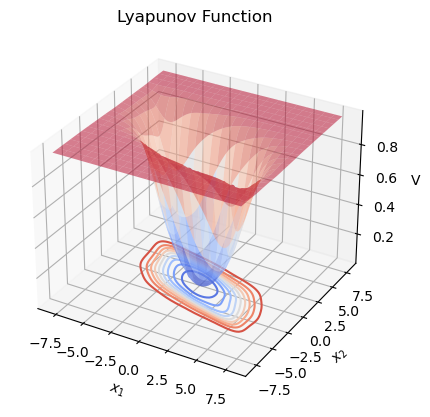

In [10]:
X = np.linspace(-8, 8, 100) 
Y = np.linspace(-8, 8, 100)
x1, x2 = np.meshgrid(X,Y)

ckpt = torch.load('./dint/ckpts/3000.pth', map_location='cpu')
network = TanhNetwork([2, 20, 20, 1], final_act='sigmoid')
network.load_state_dict(ckpt['W'])
actor = TanhNetwork([2, 10, 10, 1], final_act='tanh')
actor.load_state_dict(ckpt['C'])

def f_torch(self, x, u):
        """
        :param x: [batch, 2], torch.tensor
          x[:,0] = \theta
          x[:,1] = \dot\theta
        :param u: [batch, 1], torch.tensor
        """
        return torch.stack([x[:, 1], u[:,0]], dim=1)

def f_ours(y, t):
    x1, x2 = y
    u = pipe(
        np.stack([x1, x2], axis=-1),
        np_to_torch,
        actor,
        torch_to_np
    )
    dydt = [x2, u]
    return dydt

V_ours = torch_to_np(
    network(
        np_to_torch(np.stack([x1, x2], axis=-1))
    )
)

V_lqr = 1.73205081*x1**2 + 2*1.*x1*x2 + 1.73205081*x2**2

ax = Plot3D(x1,x2,V_ours)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('V')
plt.title('Lyapunov Function')
plt.savefig('./dint/dint_3d.png')
plt.show()
plt.close()

/var/folders/qm/flyz5txs1c79_bp8msg25mqc0000gn/T/ipykernel_64610/3987028329.py:8: UserWarning: The following kwargs were not used by contour: 'linewidth'
  ax.contour(X,Y,V_ours, [0.7], linewidth=2, colors='r')
/var/folders/qm/flyz5txs1c79_bp8msg25mqc0000gn/T/ipykernel_64610/3987028329.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  ax.contour(X,Y,V_lqr, [0.57716], linewidth=2, colors='m')


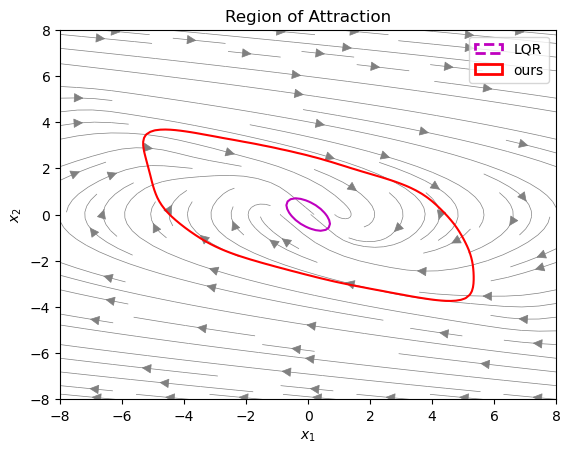

In [12]:
ax = plt.gca()
xd = np.linspace(-8, 8, 10) 
yd = np.linspace(-8, 8, 10)
Xd, Yd = np.meshgrid(xd,yd)
t = np.linspace(0,2,100)
Plotflow(Xd, Yd, t, f_ours) 

ax.contour(X,Y,V_ours, [0.7], linewidth=2, colors='r')
ax.contour(X,Y,V_lqr, [0.57716], linewidth=2, colors='m')

plt.title('Region of Attraction')
plt.legend(
    [
        plt.Rectangle((0,0),1,2,color='m',fill=False,linewidth = 2, linestyle='--'),
        plt.Rectangle((0,0),1,2,color='r',fill=False,linewidth = 2),
    ],
    [
        'LQR',
        'ours'
    ],
    loc='upper right'
)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.savefig('./dint/dint_2d.png')
plt.show()
plt.close()

# Van der Pol

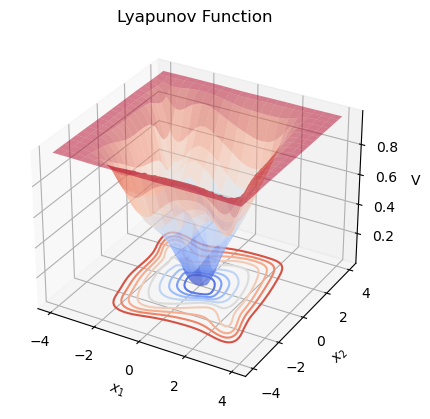

In [13]:
X = np.linspace(-4, 4, 100) 
Y = np.linspace(-4, 4, 100)
x1, x2 = np.meshgrid(X,Y)

ckpt = torch.load('./vanderpol/ckpts/3000.pth', map_location='cpu')
network = TanhNetwork([2, 30, 30, 1], final_act='sigmoid')
network.load_state_dict(ckpt['W'])
actor = TanhNetwork([2, 30, 30, 1], final_act='tanh')
actor.load_state_dict(ckpt['C'])


def f_ours(y, t):
    #parameters
    mu = 1
    x1, x2 = y
    
    u = pipe(
        np.stack([x1, x2], axis=-1),
        np_to_torch,
        actor,
        torch_to_np,
    )
    dydt = [x2,  - x1 + mu * (1 - x1 ** 2) * x2 + u]
    return dydt

V_lqr = 3.37841423 * x1**2 + 2 * 0.41421356 * x1 * x2 + 2.68179283 * x2**2

V_ours = torch_to_np(
    network(
        np_to_torch(np.stack([x1, x2], axis=-1))
    )
)

ax = Plot3D(x1,x2,V_ours)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('V')
plt.title('Lyapunov Function')
plt.savefig('./vanderpol/vanderpol_3d.png')
plt.show()
plt.close()

/var/folders/qm/flyz5txs1c79_bp8msg25mqc0000gn/T/ipykernel_64610/3551541728.py:8: UserWarning: The following kwargs were not used by contour: 'linewidth'
  ax.contour(X,Y,V_ours, [0.5], linewidth=2, colors='r')
/var/folders/qm/flyz5txs1c79_bp8msg25mqc0000gn/T/ipykernel_64610/3551541728.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  ax.contour(X,Y,V_lqr, [0.37279], linewidth=2, colors='m')


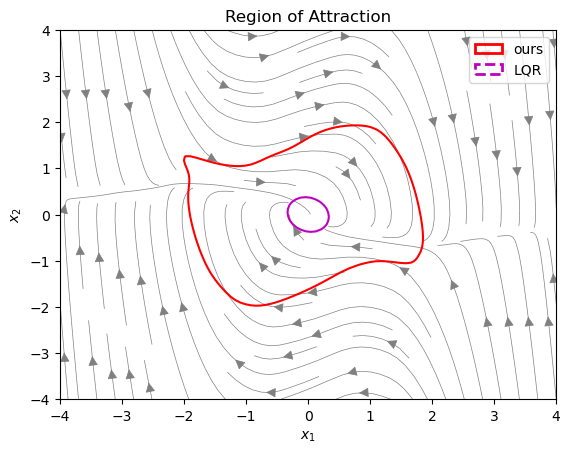

In [15]:
ax = plt.gca()
xd = np.linspace(-4, 4, 10) 
yd = np.linspace(-4, 4, 10)
Xd, Yd = np.meshgrid(xd,yd)
t = np.linspace(0,2,100)
Plotflow(Xd, Yd, t, f_ours) 

ax.contour(X,Y,V_ours, [0.5], linewidth=2, colors='r')
ax.contour(X,Y,V_lqr, [0.37279], linewidth=2, colors='m')

plt.title('Region of Attraction')
plt.legend(
    [
        plt.Rectangle((0,0),1,2,color='r',fill=False,linewidth = 2),
        plt.Rectangle((0,0),1,2,color='m',fill=False,linewidth = 2, linestyle='--'),
    ],
    [
        'ours',
        'LQR'
    ],
    loc='upper right'
)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.savefig('./vanderpol/vanderpol_2d.png')
plt.show()